# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from numpy.linalg import eig, norm, inv
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import make_moons, make_circles

# Classes + Helpers

In [2]:
def create_spiral_data(N):
  phi = 2 * np.pi * np.sqrt(np.random.rand(N))
  r1 = phi + np.pi
  r2 = - phi - np.pi

  X1 = np.array([r1 * np.cos(phi), r1 * np.sin(phi)]).T + np.random.rand(N, 2)
  X2 = np.array([r2 * np.cos(phi), r2 * np.sin(phi)]).T + np.random.rand(N, 2)
  y1 = np.ones((N, 1))
  y2 = -np.ones((N, 1))

  data = np.concatenate((np.concatenate((X1, X2), axis=0), np.concatenate((y1, y2), axis=0)), axis=1)
  np.random.shuffle(data)
  X = data[:, :-1]
  y = data[:, -1].flatten()

  return X, y


def scale(X_train, X_test):
  scaler = MinMaxScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  return X_train_scaled, X_test_scaled


def plot_data(X, y):
  plt.figure(figsize=(30, 10))
  plt.scatter(X[:, 0], X[:, 1], c=y)
  plt.title('Spiral data - 2D')
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.show()

In [3]:
class KPCA_plus_LDA:

  def __init__(self, n_components=2, kernel_type='linear', gamma=1.0, c=0.0, degree=1):
    self.gamma = gamma
    self.kernel_type = kernel_type
    self.c = c
    self.degree = degree
    self.n_components = n_components

  # =============================== KPCA =====================================
  def kernel(self, X1, X2):
    if self.kernel_type == 'linear':
      return np.dot(X1, np.transpose(X2)) + self.c 
    elif self.kernel_type == 'poly':
      return (np.dot(X1, np.transpose(X2)) + self.c) ** self.degree 
    elif self.kernel_type == 'rbf':
      if self.gamma == None:
        self.gamma = 1 / X1.shape[-1]  # 1 / D
      if (X1.ndim == 1) and (X2.ndim == 1):
        return np.exp(-self.gamma * np.linalg.norm(X1 - X2) ** 2)
      elif ((X1.ndim > 1) and (X2.ndim == 1)) or ((X1.ndim == 1) and (X2.ndim > 1)):
        return np.exp(-self.gamma * np.linalg.norm(X1- X2, axis=1) ** 2)
      elif (X1.ndim > 1) and (X2.ndim > 1):
        return np.exp(-self.gamma * np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], axis=2) ** 2)
    elif self.kernel_type == 'sigmoid':
      return np.tanh(self.gamma * np.dot(X1, np.transpose(X2)) + self.c)

  def kpca_fit_transform(self, X):
    self.X = X
    self.N, self.D = self.X.shape
    self.K = self.kernel(self.X , self.X)
    I = np.ones((self.N, self.N)) / self.N
    KI, IK = np.dot(self.K, I), np.dot(I, self.K)
    self.K_tilde = self.K - IK - KI + np.dot(IK, I)
    self.lambdas, self.alphas = eig(self.K_tilde)
    sort_idx = np.argsort(np.real(self.lambdas))[::-1]
    self.lambdas = np.real(self.lambdas[sort_idx][:self.n_components])
    self.alphas = np.real(self.alphas[:, sort_idx][:, :self.n_components])
    self.diag = np.diag(1/np.sqrt(self.lambdas))
    return np.dot(np.dot(self.K_tilde.T, self.alphas), self.diag)

  def kpca_transform(self, X):
    M, d = X.shape
    t1 = self.kernel(self.X, X)
    t2 = np.sum(self.K, axis=1) / self.N
    t2 = np.repeat(t2[:, np.newaxis], M, axis=1)
    t3 = np.sum(t1, axis=0) / self.N
    t4 = (np.sum(np.sum(self.K))) / (self.N ** 2)
    K_tilde = t1 - t2 - t3 + t4
    return np.dot(np.dot(K_tilde.T, self.alphas), self.diag)

  # =============================== LDA =====================================
  def get_covariance_matrices(self, X, y):
    N, d = X.shape
    class_labels = np.unique(y)
    self.n_classes = class_labels.shape[0]
    m0 = np.mean(X)
    Sb, Sw = np.zeros((d, d)), np.zeros((d, d))
    for c in class_labels:
      class_pos = np.where(y==c)[0]
      Nc = class_pos.shape[0]
      X_class = X[class_pos, :]
      m_class = np.mean(X_class, axis=0)
      Sb += Nc * np.outer(m_class - m0, m_class - m0)
      Sw += np.dot((X_class - m_class).T, X_class - m_class)
    Sb /= N
    Sw /= N

    return Sb, Sw

  def get_P1_and_U(self):
    lambdas, alphas = eig(self.Sw)

    # find REGULAR discriminant feature vectors
    sort_idxs = np.argsort(np.real(lambdas))[::-1]
    lambdas = np.real(lambdas[sort_idxs])
    self.alphas = np.real(alphas[:, sort_idxs])
    self.pos_lambdas = lambdas[lambdas > 1e-5]
    self.P1 = alphas[:, :self.pos_lambdas.shape[0]]
    Sb_tilde = np.dot(self.P1.T, np.dot(self.Sb, self.P1))
    Sw_tilde = np.dot(self.P1.T, np.dot(self.Sw, self.P1))
    M = np.dot(inv(Sw_tilde), Sb_tilde)
    du = self.n_classes - 1
    eigvals, self.U = eig(M)
    sort_idxs = np.argsort(np.real(eigvals))[::-1]
    self.U = np.real(self.U[:, sort_idxs][:, :du])
  
  # dfvs stands for: Discriminant Feature VectorS
  def get_regular_dfvs(self, X):
    return np.dot(X, np.dot(self.P1, self.U))

  def get_P2_and_V(self):
    self.P2 = self.alphas[:, self.pos_lambdas.shape[0]:]
    Sb_hat = np.dot(self.P2.T, np.dot(self.Sb, self.P2))
    dv = self.n_classes - 1
    eigvals, V = eig(Sb_hat)
    sort_idxs = np.argsort(abs(eigvals))[::-1]
    self.V = np.real(V[:, sort_idxs][:, :dv])

  def get_irregular_dfvs(self, X):
    return np.dot(X, np.dot(self.P2, self.V))
  
  def kpca_plus_lda_fit(self, X, y):
    # STEP 1: implement KPCA
    self.X_kpca = self.kpca_fit_transform(X, self.n_components)

    # STEP 2: construct Sb and Sw
    self.Sb, self.Sw = self.get_covariance_matrices(self.X_kpca, y)

    # STEP 3: get matrices P1 and U
    self.get_P1_and_U()

    # STEP 4: get matrices P2 and V
    self.get_P2_and_V()
  
  def kpca_plus_lda_transform(self, X):
    # Implement KPCA
    X_kpca = self.kpca_fit_transform(X)

    # Find REGULAR discriminant feature vectors
    self.z1 = self.get_regular_dfvs(X_kpca)   

    # Find IR-REGULAR discriminant feature vectors
    self.z2 = self.get_irregular_dfvs(X_kpca)

    # Calculate the transformed matrix
    self.X_transformed = np.concatenate((self.z1, self.z2), axis=1)

    return self.X_transformed 

  def kpca_plus_lda_fit_transform(self, X, y):
    # STEP 1: implement KPCA
    self.X_kpca = self.kpca_fit_transform(X)

    # STEP 2: construct Sb and Sw
    self.Sb, self.Sw = self.get_covariance_matrices(self.X_kpca, y)

    # STEP 3: find REGULAR discriminant feature vectors
    self.get_P1_and_U()
    self.z1 = self.get_regular_dfvs(self.X_kpca)

    # STEP 4: find IR-REGULAR discriminant feature vectors
    self.get_P2_and_V()
    self.z2 = self.get_irregular_dfvs(self.X_kpca)

    # STEP 5: Calculate the transformed matrix
    self.X_transformed = np.concatenate((self.z1, self.z2), axis=1)

    return self.X_transformed 

# 1. Half-Moon dataset

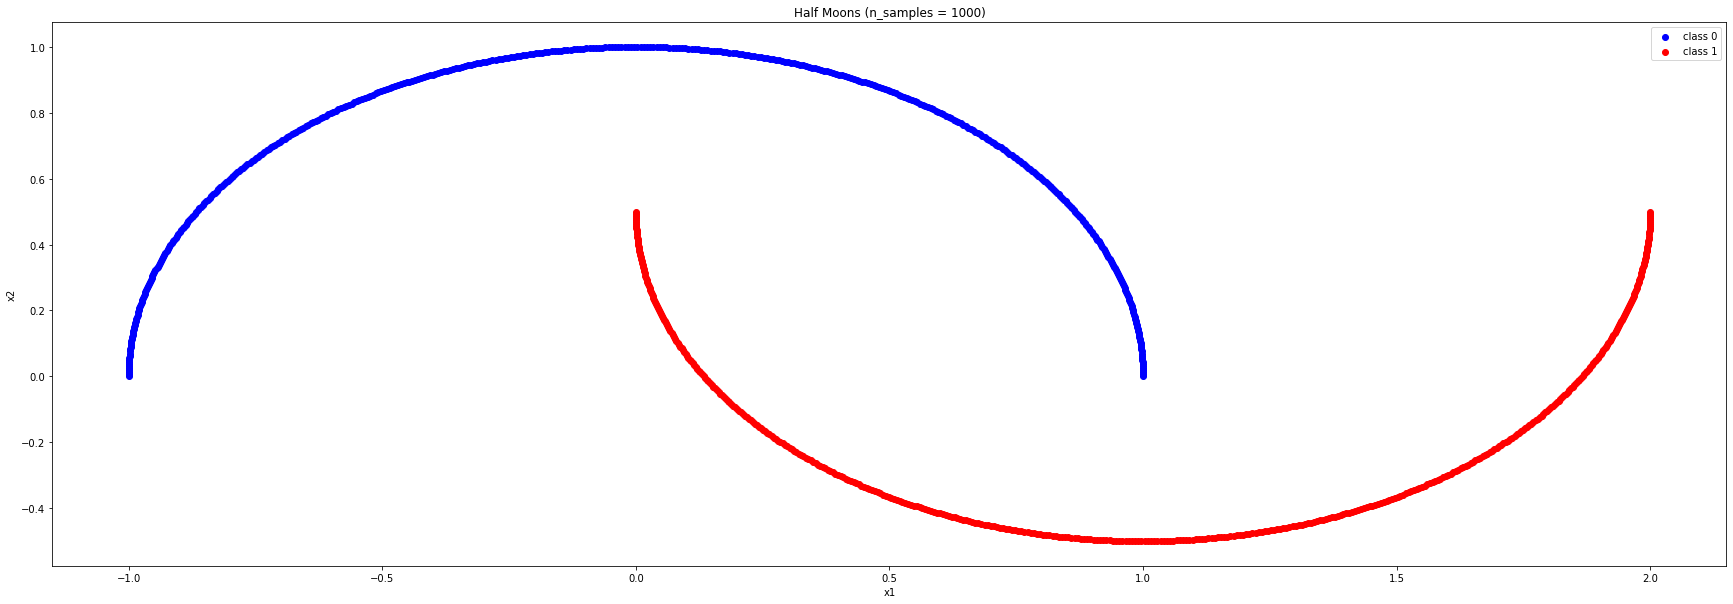

In [5]:
n_samples = 1000
X, y = make_moons(n_samples=n_samples)
X0, X1 = X[y==0], X[y==1]
plt.figure(figsize=(30, 10))
plt.scatter(X0[:, 0], X0[:, 1], c='b', label="class 0")
plt.scatter(X1[:, 0], X1[:, 1], c='r', label="class 1")
plt.title(f"Half Moons (n_samples = {n_samples})")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

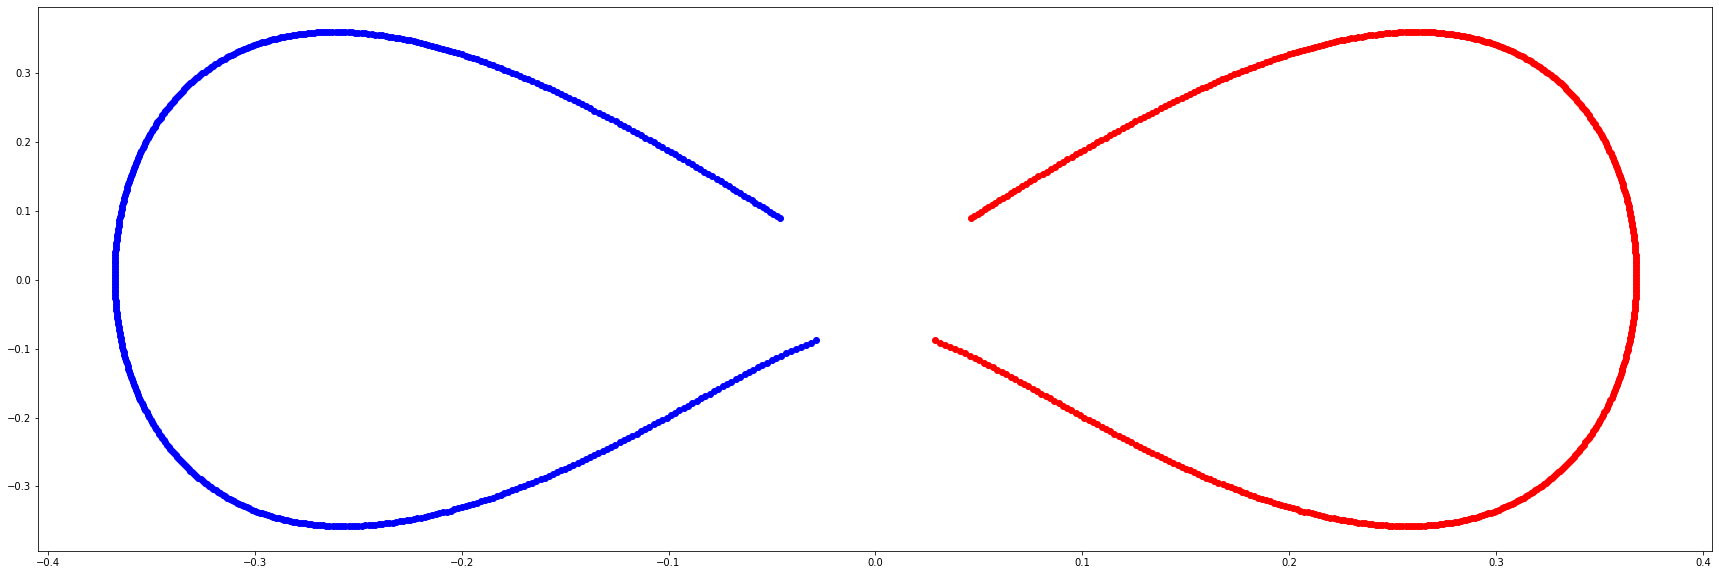

In [ ]:
kpca = KPCA_plus_LDA(n_components=2, kernel_type='rbf', gamma=15)
X_transformed = kpca.kpca_fit_transform(X)

X0_transformed = X_transformed[y==0]
X1_transformed = X_transformed[y==1]

plt.figure(figsize=(30, 10))
plt.scatter(X0_transformed[:, 0], X0_transformed[:, 1], c='b')
plt.scatter(X1_transformed[:, 0], X1_transformed[:, 1], c='r')

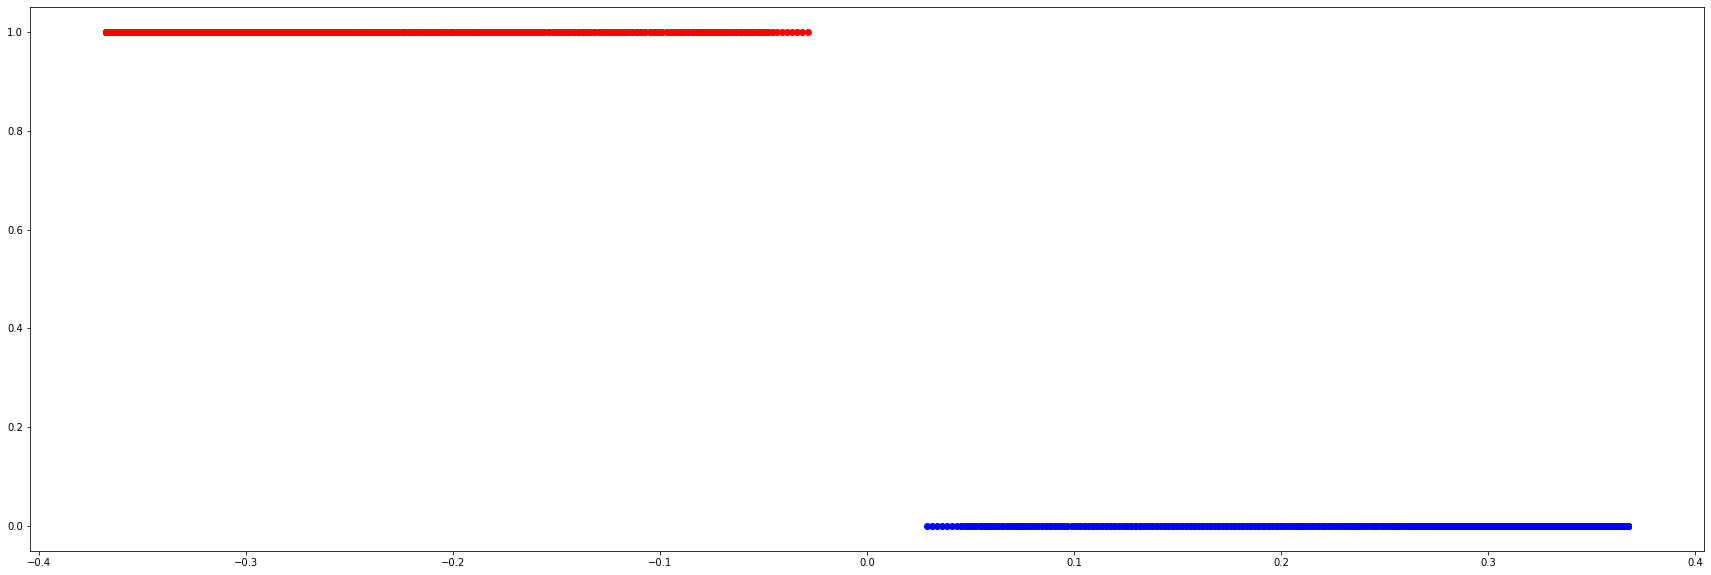

In [ ]:
kpca_plus_lda = KPCA_plus_LDA(n_components=2, kernel_type='rbf', gamma=15)
X_transformed = kpca_plus_lda.kpca_plus_lda_fit_transform(X, y)

X0_transformed = X_transformed[y==0]
X1_transformed = X_transformed[y==1]

plt.figure(figsize=(30, 10))
plt.scatter(X0_transformed.flatten(), y[y==0], c='b')
plt.scatter(X1_transformed.flatten(), y[y==1], c='r')

# 2. Concentric-Circles dataset

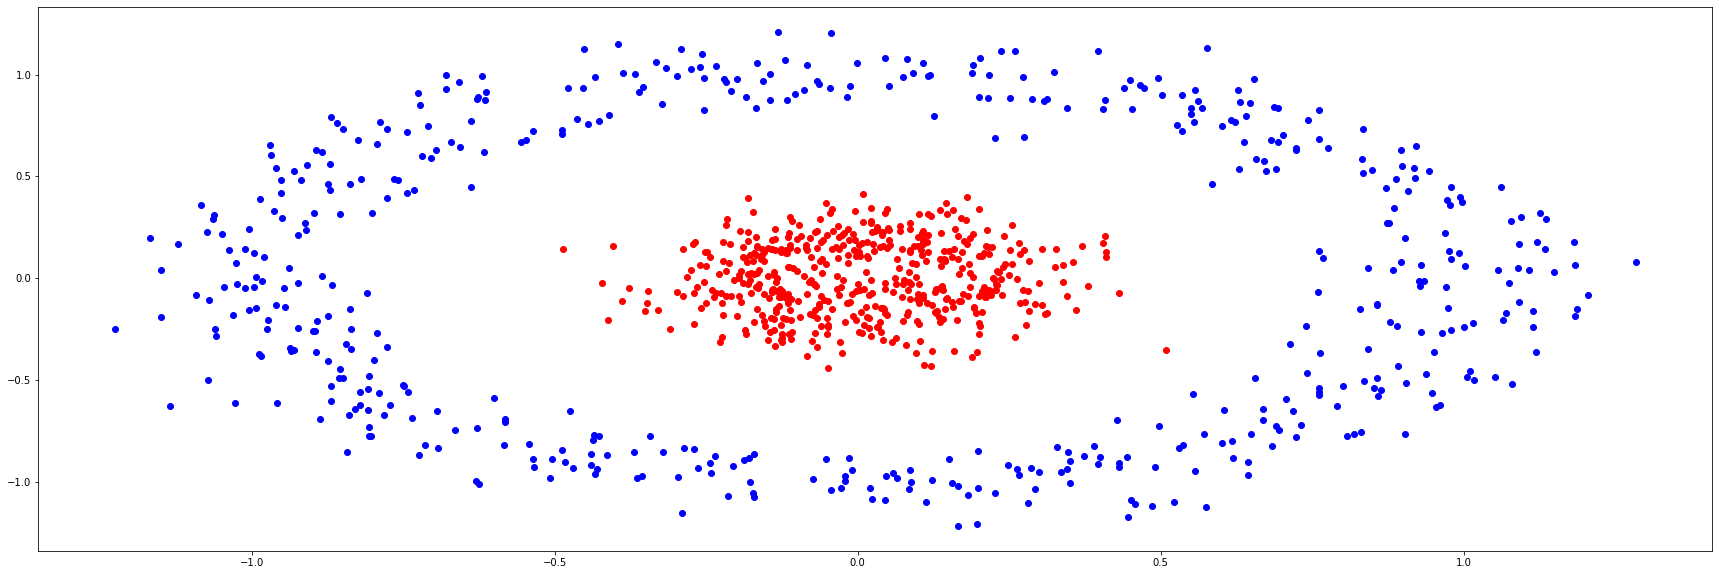

In [94]:
X, y = make_circles(n_samples=1000, noise=0.1, factor=0.2)
X0, X1 = X[y==0], X[y==1]
plt.figure(figsize=(30, 10))
plt.scatter(X0[:, 0], X0[:, 1], c='b')
plt.scatter(X1[:, 0], X1[:, 1], c='r')
plt.show()

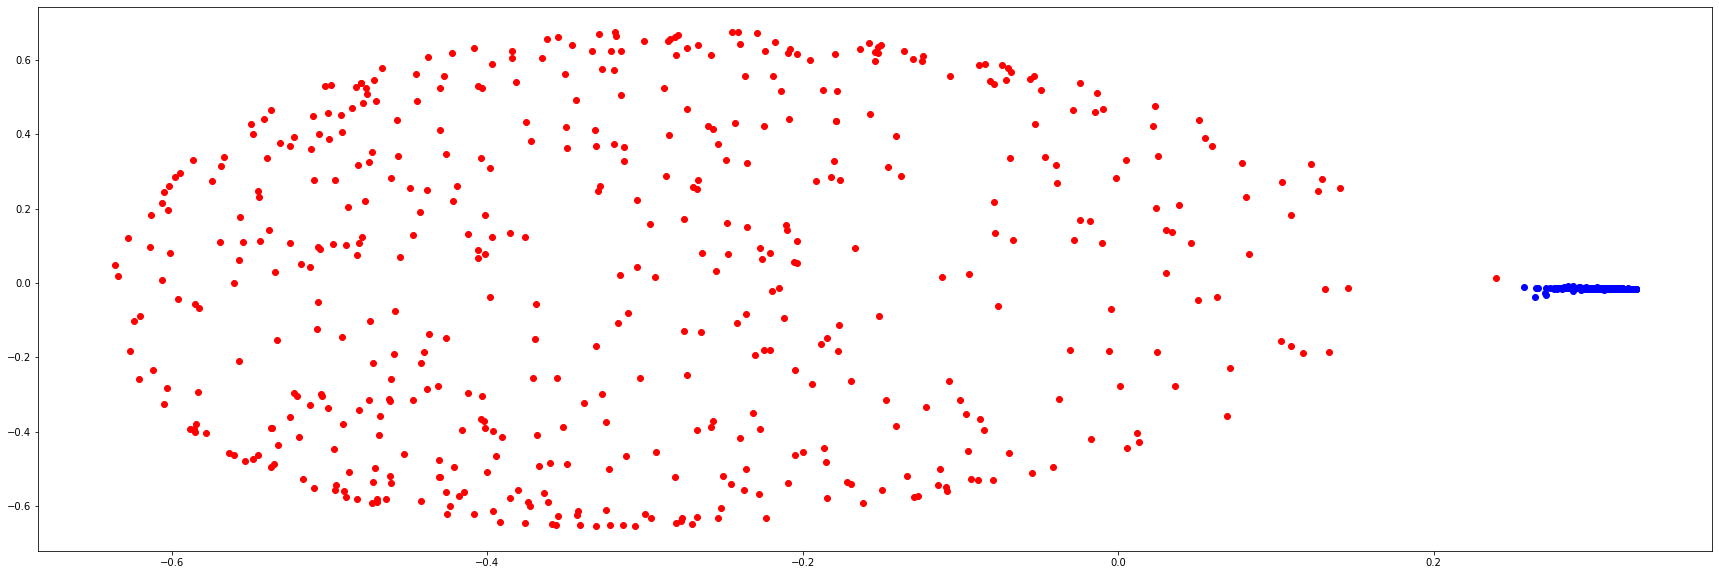

In [95]:
kpca = KPCA_plus_LDA(n_components=2, kernel_type='rbf', gamma=15)
X_transformed = kpca.kpca_fit_transform(X)

X0_transformed = X_transformed[y==0]
X1_transformed = X_transformed[y==1]

plt.figure(figsize=(30, 10))
plt.scatter(X0_transformed[:, 0], X0_transformed[:, 1], c='b')
plt.scatter(X1_transformed[:, 0], X1_transformed[:, 1], c='r')

In [96]:
svm = SVC(C=100, kernel='linear')
svm.fit(X_transformed, y)
y_preds = svm.predict(X_transformed)
accuracy = float("{:.2f}".format(100*np.mean(y_preds == y)))
print(f"Test Accuracy = {accuracy} %")

Test Accuracy = 99.9 %


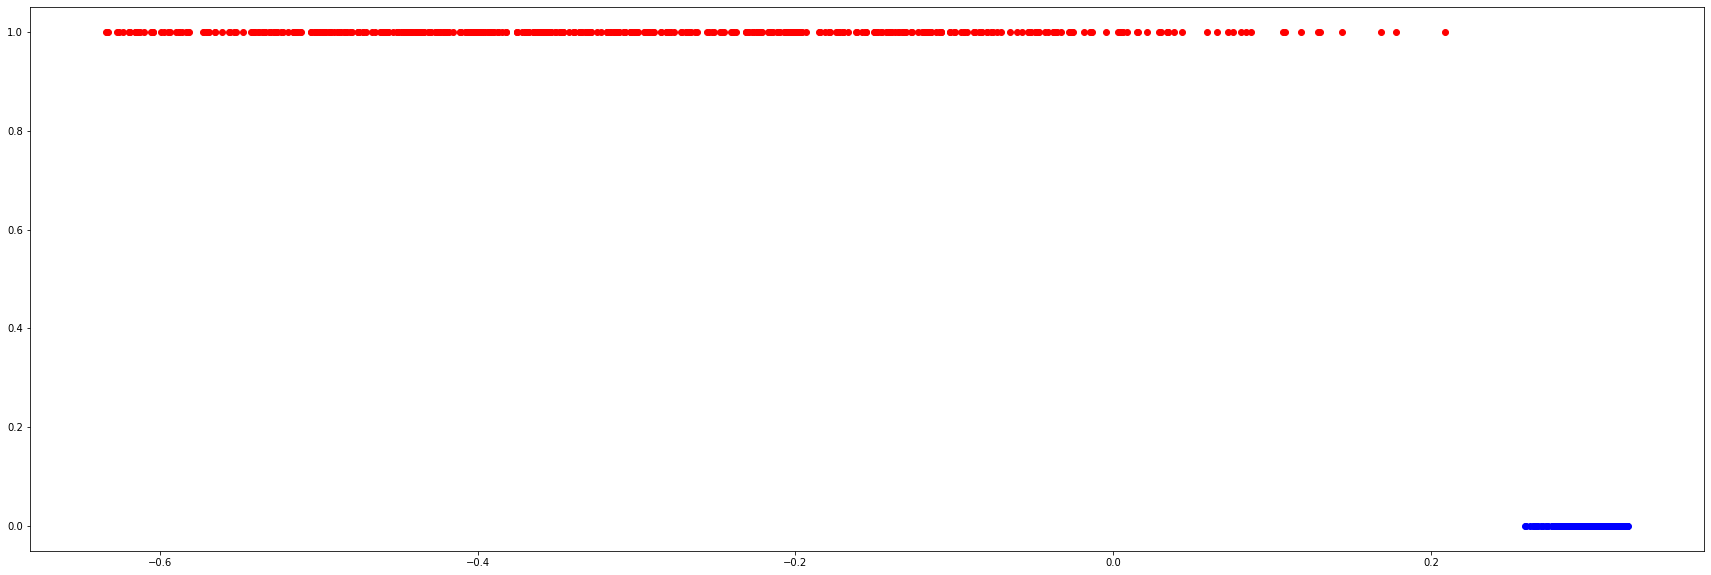

In [65]:
kpca_plus_lda = KPCA_plus_LDA(n_components=2, kernel_type='rbf', gamma=15)
X_transformed = kpca_plus_lda.kpca_plus_lda_fit_transform(X, y)

X0_transformed = X_transformed[y==0]
X1_transformed = X_transformed[y==1]

plt.figure(figsize=(30, 10))
plt.scatter(X0_transformed.flatten(), y[y==0], c='b')
plt.scatter(X1_transformed.flatten(), y[y==1], c='r')

# 3. Spiral dataset

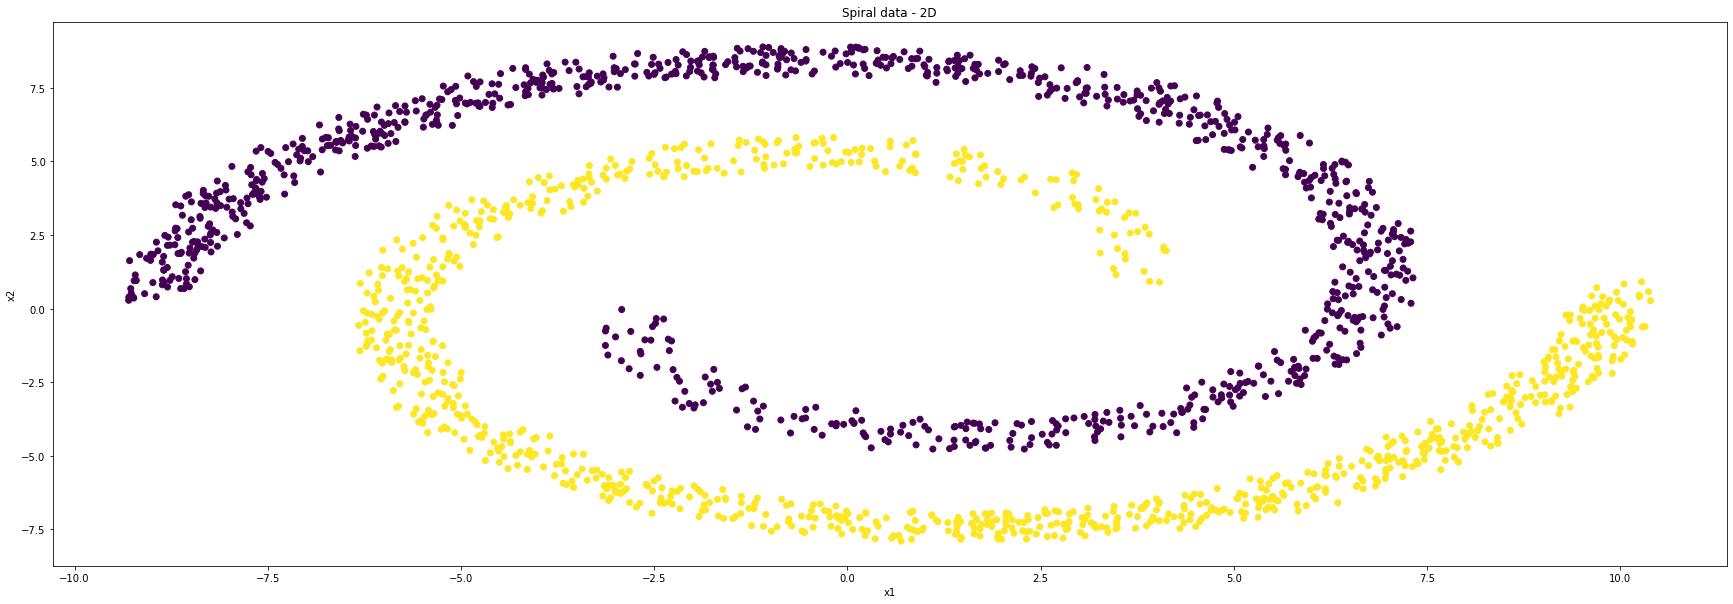

In [86]:
N_train = 1000
N_test = 100

# create data
X_train, y_train = create_spiral_data(N_train)
X_test, y_test = create_spiral_data(N_test)

# plot train data
plot_data(X_train, y_train)

# scale data
X_train_scaled, X_test_scaled = scale(X_train, X_test)

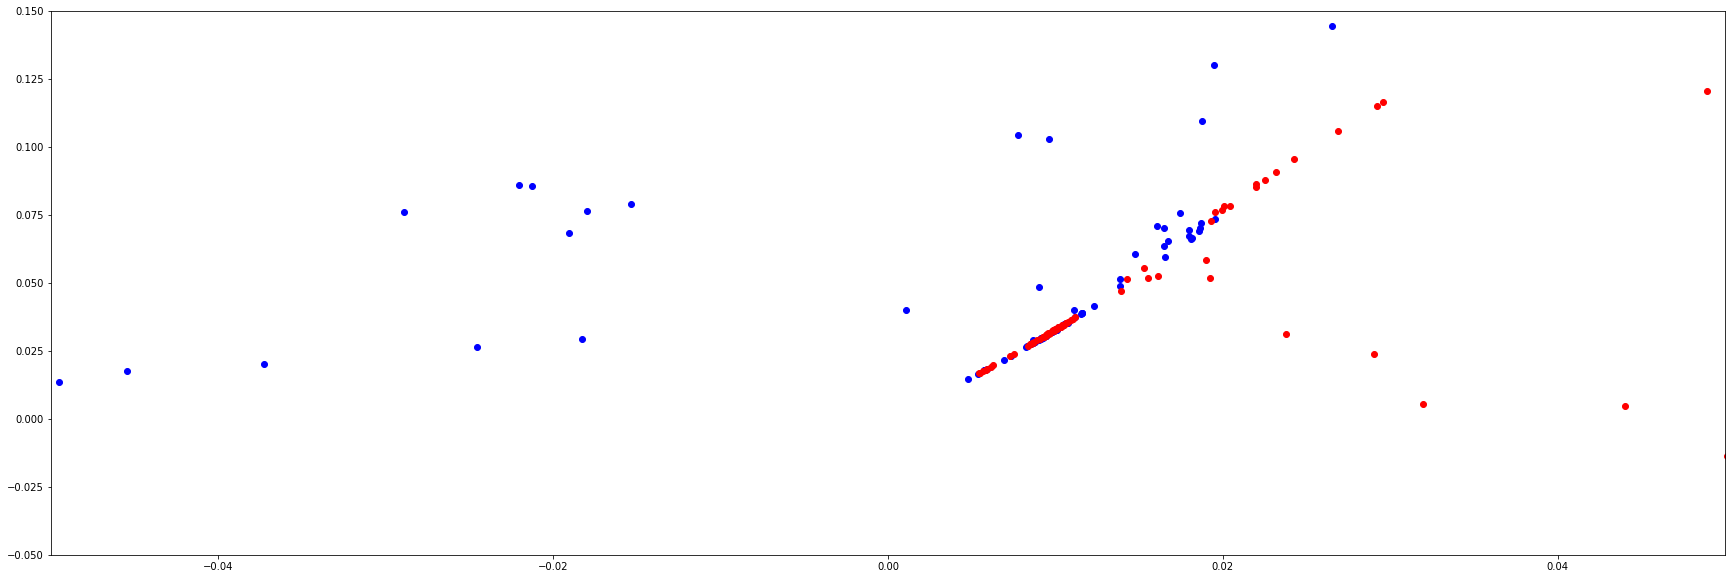

In [92]:
n_components = 2
kernel = 'rbf'
gamma = 500

kpca = KPCA_plus_LDA(n_components=n_components, kernel_type=kernel, gamma=gamma)
X_train_transformed = kpca.kpca_fit_transform(X_train_scaled)
X_test_transformed = kpca.kpca_transform(X_test_scaled)

X0 = X_test_transformed[y_test==1]
X1 = X_test_transformed[y_test==-1]

plt.figure(figsize=(30, 10))
plt.scatter(X0[:, 0], X0[:, 1], c='b')
plt.scatter(X1[:, 0], X1[:, 1], c='r')
plt.xlim([-0.05, 0.05])
plt.ylim([-0.05, 0.15])
plt.show()

In [93]:
svm = SVC(C=100, kernel='linear')
svm.fit(X_train_transformed, y_train)
y_preds = svm.predict(X_test_transformed)
accuracy = float("{:.2f}".format(100*np.mean(y_preds == y_test)))
print(f"Test Accuracy = {accuracy} %")

Test Accuracy = 66.5 %


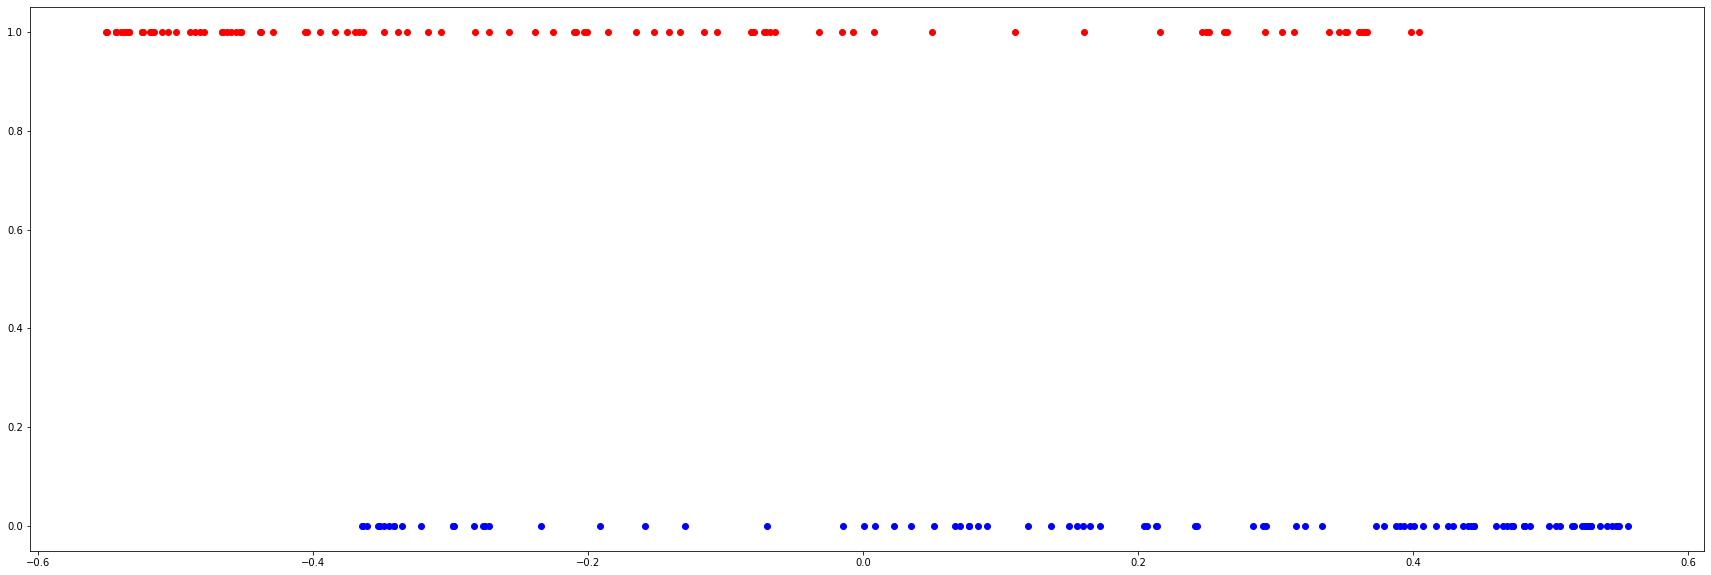

In [77]:
my_obj = KPCA_plus_LDA(n_components=n_components, kernel_type=kernel)
X_train_transformed = my_obj.kpca_plus_lda_fit_transform(X_train_scaled, y_train)
X_test_transformed = my_obj.kpca_plus_lda_transform(X_test_scaled)

X0 = X_test_transformed[y_test==0]
X1 = X_test_transformed[y_test==1]

plt.figure(figsize=(30, 10))
plt.scatter(X0.flatten(), y_test[y_test==0], c='b')
plt.scatter(X1.flatten(), y_test[y_test==1], c='r')